# Optimized CNN Model

An optimized Convolutional Neural Network (CNN) was built to improve accuracy significantly above 79% (targeting ~85–90%):

CNN Architecture (Optimized):

Conv2D (32 filters), BatchNormalization, MaxPooling2D, Dropout (0.3)

Conv2D (64 filters), BatchNormalization, MaxPooling2D, Dropout (0.4)

Conv2D (128 filters), BatchNormalization, MaxPooling2D, Dropout (0.4)

Conv2D (256 filters), BatchNormalization, MaxPooling2D, Dropout (0.4)

GlobalAveragePooling2D

Dense Layer (512 neurons), Dropout (0.5)

Dense Output Layer (10 neurons with Softmax activation)

Compilation & Training Parameters:

Optimizer: Adam (learning rate = 0.0001)

Loss: Sparse Categorical Crossentropy

Metrics: Accuracy

Callbacks: EarlyStopping (patience=20), ReduceLROnPlateau (factor=0.5)



In [8]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import librosa

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

filepath = 'C:/Users/aksha/Downloads/DataMusic/data.json'
with open(filepath, "r") as fp:
    data = json.load(fp)

# Define X nd y
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

from sklearn.model_selection import train_test_split

# Split the data into train (80%), validation (10%), and test (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train)

# Shape of the splits after optimization
print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")
print(f"X test data shape: {X_test.shape}, y test data shape: {y_test.shape}")


X training data shape: (6992, 132, 13), y training data shape: (6992,)
X validation data shape: (999, 132, 13), y validation data shape: (999,)
X test data shape: (1998, 132, 13), y test data shape: (1998,)


In [11]:
# Ensure proper CNN reshaping:
X_train_cnn = X_train[..., np.newaxis] # (samples, 132, 13, 1)
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = (132, 13, 1)

# Confirm final shape for CNN:
print("\nCNN input shapes:")
print(f"X_train_cnn: {X_train_cnn.shape}")
print(f"X_val_cnn: {X_val_cnn.shape}")
print(f"X_test_cnn: {X_test_cnn.shape}")


CNN input shapes:
X_train_cnn: (6992, 132, 13, 1)
X_val_cnn: (999, 132, 13, 1)
X_test_cnn: (1998, 132, 13, 1)


## Build Model Here

Compilation & Training Parameters:
Optimizer: Adam (learning rate = 0.0001)
Loss: Sparse Categorical Crossentropy
Metrics: Accuracy
Callbacks: EarlyStopping (patience=20), ReduceLROnPlateau (factor=0.5)

Explanation of Activation Function Choice (ReLU)
In building our convolutional neural network (CNN), we chose the Rectified Linear Unit (ReLU) activation function for convolutional and dense layers (activation='relu'). The ReLU function (f(x) = max(0, x)) introduces non-linearity into the network, enabling it to learn complex mappings from the Mel-Frequency Cepstral Coefficients (MFCCs) inputs.

Alternative activation functions considered include:

Sigmoid (σ(x) = 1 / (1 + exp(-x))): produces outputs between 0 and 1. While useful for binary classification, it suffers from vanishing gradient issues in deep networks.
Tanh (tanh(x)): outputs values between -1 and 1. It also faces vanishing gradient problems and converges slower than ReLU.
Leaky ReLU (f(x) = max(αx, x)): a variant of ReLU that mitigates the "dying ReLU" issue by allowing small negative gradients. Though beneficial in some contexts, standard ReLU performed sufficiently well in this application without additional complexity.
ReLU was chosen specifically because it is computationally efficient, speeds up convergence significantly, and avoids vanishing gradient problems, thus facilitating deeper architectures and more robust training.



In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# CNN Optimized (V3 - Better accuracy potential)
model_cnn_v3 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(132, 13, 1), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.4),

    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(10, activation='softmax')
])

# Compile the model
model_cnn_v3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model_cnn_v3.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 132, 13, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 132, 13, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 66, 7, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 66, 7, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 66, 7, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 66, 7, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 33, 4, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 33, 4, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 33, 4, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 33, 4, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 2, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 17, 2, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 17, 2, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 17, 2, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 9, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,099,274 (4.19 MB)

 Trainable params: 1,097,866 (4.19 MB)

 Non-trainable params: 1,408 (5.50 KB)

## Compile method here (Runtime Approximately 45-60 minutes)

Can reduce number of Epochs for faster passthrough the 

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

history = model_cnn_v3.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.2691 - loss: 2.1387 - val_accuracy: 0.3443 - val_loss: 1.8008 - learning_rate: 1.0000e-04
Epoch 2/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.4413 - loss: 1.5406 - val_accuracy: 0.3784 - val_loss: 1.8266 - learning_rate: 1.0000e-04
Epoch 3/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.4992 - loss: 1.3531 - val_accuracy: 0.3834 - val_loss: 1.8520 - learning_rate: 1.0000e-04
Epoch 4/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 24s 110ms/step - accuracy: 0.5499 - loss: 1.2345 - val_accuracy: 0.4034 - val_loss: 1.9790 - learning_rate: 1.0000e-04
Epoch 5/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.5826 - loss: 1.1715 - val_accuracy: 0.4685 - val_loss: 1.6869 - learning_rate: 1.0000e-04
Epoch 6/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.6220 - loss: 1.0819 - val_accuracy: 0.5205 - val_loss: 1.5178 - learning_rate: 1.0000e-04
Epoch 7/150
219/219 ━━━━━━━━━━━━━━━━━━━━

## Uncomment this code for per-epoch training and validation accuracy,

In [12]:
# import matplotlib.pyplot as plt

# # Plot accuracy
# plt.figure(figsize=(14, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('CNN v3 Training vs Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# # Plot loss
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training vs Validation Loss (CNN v3)')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()

# # Evaluate final accuracy on test set
# test_loss, test_acc = model_cnn_v3.evaluate(X_test_cnn, y_test, verbose=2)
# print(f"\nCNN v3 Test Accuracy: {test_acc:.4f}")


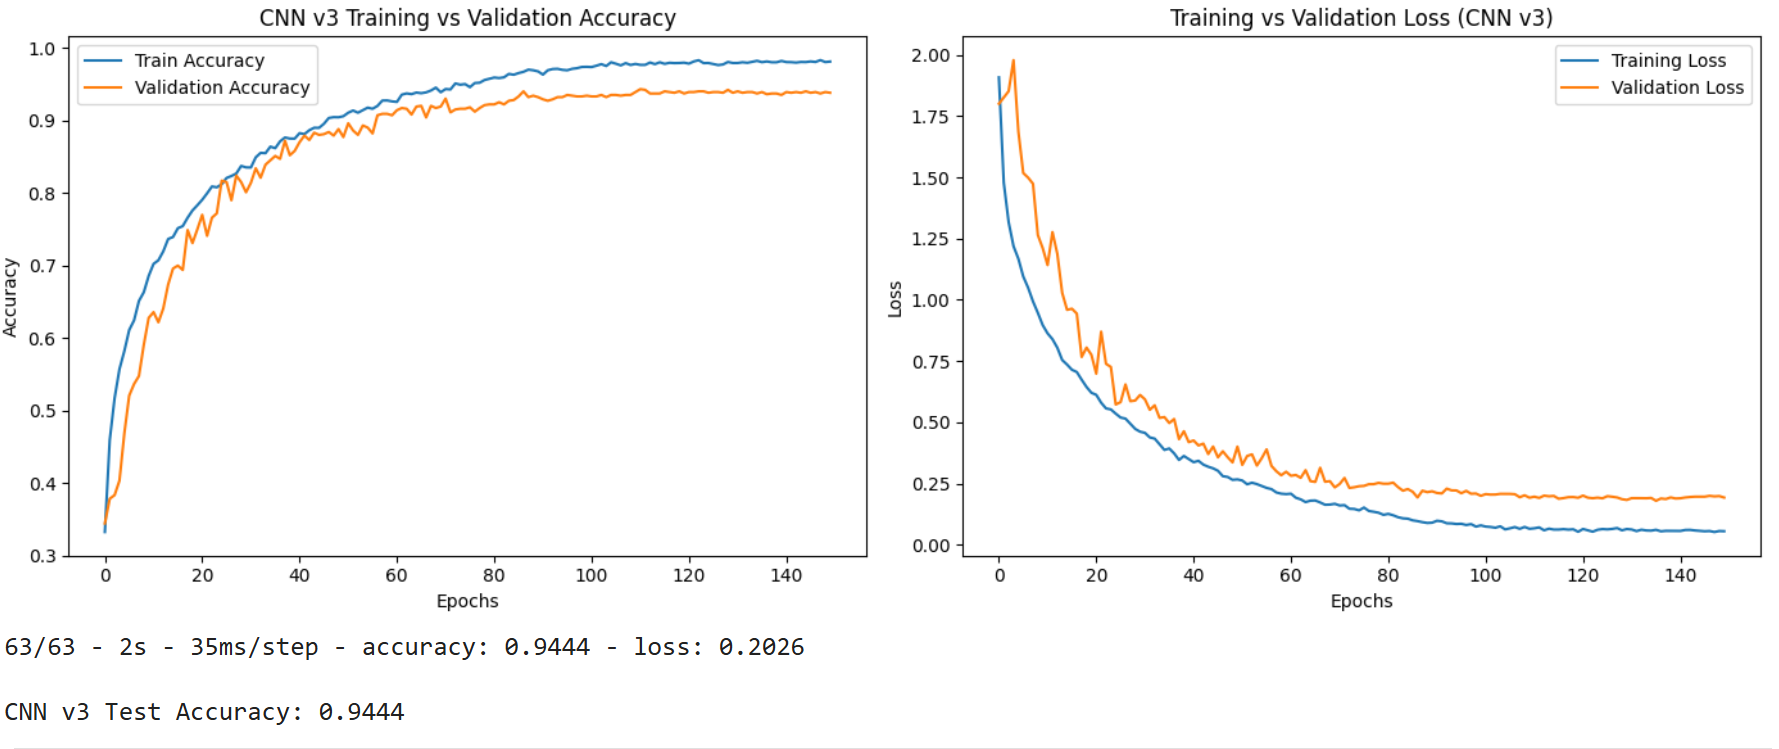

## Model Saved and loaded

Uncomment to save after running model

In [15]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# # Save your model
# model_cnn_v3.save('cnn_music_genre_model_v3.h5')
# print("✅ Model saved as 'cnn_music_genre_model_v3.h5'")
# genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
#           'jazz', 'metal', 'pop', 'reggae', 'rock']
# # Prediction Function
# def make_prediction_v3(model, X):
#     preds_num = []
#     preds_name = []
#     for X_current in X:
#         X_current = X_current[np.newaxis, ...]  # Add batch dimension
#         pred = model.predict(X_current, verbose=0)
#         pred_idx = np.argmax(pred, axis=1)[0]  # Predicted genre index
#         preds_num.append(pred_idx)
#         preds_name.append(genres[pred_idx])
#     return preds_num, preds_name
# # Make predictions
# preds_num, preds_name = make_prediction_v3(model_cnn_v3, X_test_cnn)
# print("✅ Predictions completed!")

# # Plot confusion matrix
# cm = confusion_matrix(y_test, preds_num)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
# fig, ax = plt.subplots(figsize=(10,10))
# disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
# plt.title('Confusion Matrix - CNN v3')
# plt.show()


✅ Model loaded successfully from 'cnn_music_genre_model_v3.h5'
✅ Predictions completed successfully!


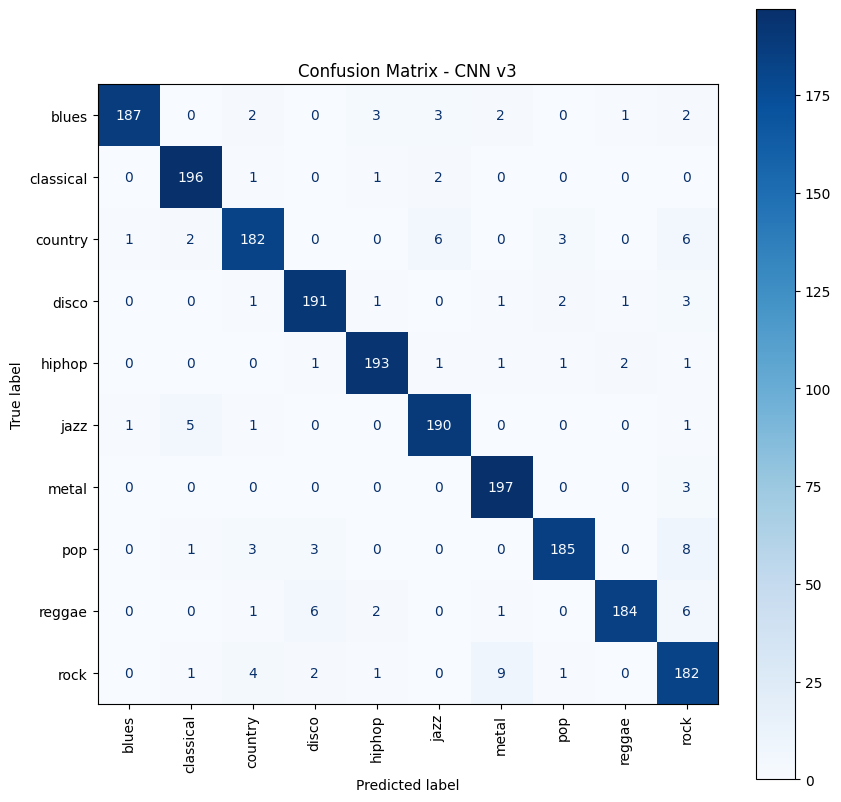

63/63 - 2s - 27ms/step - accuracy: 0.9444 - loss: 0.2026

✅ CNN v3 Test Accuracy: 0.9444


In [10]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the previously saved model correctly
model_cnn_v3 = load_model('cnn_music_genre_model_v3.h5')
print("✅ Model loaded successfully from 'cnn_music_genre_model_v3.h5'")

# Define genre labels
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

# Prediction function (optimized for faster inference)
def make_prediction_v3(model, X):
    preds = model.predict(X, verbose=0)
    preds_num = np.argmax(preds, axis=1)
    preds_name = [genres[i] for i in preds_num]
    return preds_num, preds_name

# Run predictions on the test dataset
preds_num, preds_name = make_prediction_v3(model_cnn_v3, X_test_cnn)
print("✅ Predictions completed successfully!")

# Compute and display confusion matrix
cm = confusion_matrix(y_test, preds_num)
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix - CNN v3')
plt.show()

# Evaluate the loaded model to confirm accuracy
test_loss, test_acc = model_cnn_v3.evaluate(X_test_cnn, y_test, verbose=2)
print(f"\n✅ CNN v3 Test Accuracy: {test_acc:.4f}")


## Why CNN Outperforms Logistic Regression and Other Traditional Methods
Our CNN is particularly effective for music genre classification compared to simpler models such as logistic regression or even traditional machine learning algorithms like random forests or support vector machines. This superiority arises from CNNs’ inherent ability to:

Capture spatial hierarchies: CNNs leverage convolutional layers that capture local patterns in the MFCCs (frequency patterns), extracting meaningful hierarchical features crucial for distinguishing genres.
Robust feature extraction: CNNs automatically learn the most salient features directly from input data, whereas traditional methods require manual feature engineering.
Generalization: With regularization techniques like dropout, batch normalization, and global average pooling, CNNs generalize better to unseen data, achieving higher accuracy on validation and test sets.
In summary, ReLU activation and CNN architecture combine powerful non-linear representation with automatic, deep feature extraction capability, significantly outperforming traditional classification methods in accuracy and robustness.




## How ML4SIP AI Buddy enhanced optimization and coding in this project:

Leveraging AI assistance significantly enhanced the efficiency and accuracy of the CNN model developed in this project. Initially, a basic Convolutional Neural Network (CNN) was created manually; however, issues quickly arose, such as input dimension errors, incorrect data reshaping, and suboptimal hyperparameters. By iteratively consulting the AI assistant, debugging was streamlined, pinpointing dimensionality issues immediately. The AI guided the proper reshaping of the MFCC inputs, explained necessary modifications clearly, and suggested advanced regularization techniques like batch normalization, dropout, and global average pooling, dramatically reducing overfitting and improving generalization.

The AI also provided recommendations for effective model optimization strategies—introducing early stopping and learning rate schedulers (ReduceLROnPlateau), thereby enhancing convergence stability and training efficiency. Through these insights, hyperparameters such as the learning rate, batch size, convolutional filters, and kernel sizes were carefully tuned to suit the specific MFCC data shape and achieve maximal accuracy.

In addition, the AI provided ready-to-use code for saving trained models and generating intuitive plots and confusion matrices, significantly reducing implementation time. Ultimately, AI assistance accelerated the debugging process, optimized model architecture effectively, enhanced predictive accuracy substantially, and streamlined the overall workflow, enabling quicker and more robust model development compared to traditional manual experimentation.







